# Simplified version of winning NN in CorporacionVavorita Grocery Sales Forceasting

Stuggling to understand what is happening in the [1st Place NN Model](https://www.kaggle.com/shixw125/1st-place-nn-model-public-0-507-private-0-513/code)?

Don't feel bad - even the winner doesn't seem to understand it. After hours of looking at the code I kept asking myself ... "what is actually happening here?"

The code actually isn't bad once you understand the basic feature engineering. Unfortuately none of it is obvious at first (or second, third...) glance.

What follows is a simplified example of the feature engineering and training data prep. 

### The key data prep steps
The key difference from this example and the [Rossman example Jeremy Howard created](https://github.com/fastai/courses/blob/master/deeplearning2/rossman.ipynb) is in the organization of the training examples.

The training examples are not organized by date - that is, date isn't the index for the training dataframes. Instead the training dataframe index is a multipart store,item combination. If this is totally clear to you based on my description ... well you're smarter than I am. 

1. Build dataframes indexed on store,item with dates as columns. The dataframe values can be any data over which you can generate date-based features. For example, "average sales for this item/store combination from the previous 3 days"
2. Pick a date and build date-based features based on this date. For example, "May 31, 2017". Then calculate the average sales for the preceding 3 days for every item/store combination.
3. Pick another date such as "June 30, 2017" and repeat step 2. Then row-wise concatenate the featues from May 31 and June 30.

The winning notebook basically keeps repeating those steps. 

1. Lines 56-87 create the dataframes.
2. The get_timespam and prepare_dataset functions build the date-based features.
3. The for i in range(num_days) loop on line 164 builds features for additional dates.

I left out a few details such as merging other item/store features. Once you understand these 3 steps you'll see how it works.

## Load libraries

In [1]:
gpu=0
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=$gpu
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os,sys
sys.path.insert(1, '/home/kevin/fastai')
from fastai.structured import *
from fastai.column_data import *
from IPython.display import HTML
np.set_printoptions(threshold=50, edgeitems=20)
from datetime import date, timedelta

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


## Functions

In [2]:
#paths
data_path = '/home/kevin/nbs/kaggle/GrocerySales/data/'
slowdata = data_path + 'slowdisk/'; slowdata
simple = slowdata + 'replicate_winner/'
#leaves duplicate field names on left and appends with _y on right
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on=left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, suffixes=("", "_y"))

In [3]:
#normalize and denormalize targets
def normy(y):
    meany=np.mean(y)
    stdevy = np.std(y)
    ynorm = (y-meany)/stdevy
    return meany, stdevy, ynorm

def denorm(y, meany, stdevy, r=3):
    return np.round(y*stdevy+meany, r)

#custom function I wrote to add a null check
def apply_cats(df, trn, null_check=False):
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = pd.Categorical(c, categories=trn[n].cat.categories, ordered=True)
            if null_check and df[n].isnull().values.any():
                raise ValueError(f'Target dataframe has null values for column {n}. This can occur if the target dataframe has category values not present in original.')

## Load and clean data

In [4]:
# specify datatypes before loading the data will save you a ton of memory.
dtypes = {'id': np.uint32,
          'store_nbr': np.uint8, 
          'item_nbr': np.uint32, 
          'unit_sales': np.float32,
          'class': np.uint16,
          'onpromotion': np.bool,
          'dcoilwtico':np.float16,
          'transactions':np.uint16,
          'cluster': np.uint32}

In [5]:
train = pd.read_csv(slowdata + 'train.csv', dtype=dtypes, usecols=[1,2,3,4,5], parse_dates=['date'],
                    skiprows=range(1, 86672217) #Skip dates before 2016-08-01, and id column
                   )
test = pd.read_csv(slowdata + 'test.csv', dtype=dtypes, parse_dates=['date'])
items = pd.read_csv(slowdata + 'items.csv', dtype=dtypes)
stores = pd.read_csv(slowdata + 'stores.csv', dtype=dtypes)

In [6]:
# data older than march 1 showed no improvement. Setting to Jan so code works.
train = train[train['date'] >= '2017-01-01']

In [7]:
train['unit_sales'] = train['unit_sales'].as_matrix().clip(min=0) # get rid of negs
train['unit_sales'] =  train['unit_sales'].apply(pd.np.log1p) # transform for smoother training
train['onpromotion'].fillna(False, inplace=True) # fill in the missing promotion data with 'False'
test['onpromotion'].fillna(False, inplace=True)

In [8]:
items.set_index('item_nbr', inplace=True)
stores.set_index('store_nbr', inplace=True)

#### Save and load cleaned data

In [9]:
train.to_pickle(simple + 'train_processed.pkl')
test.to_pickle(simple + 'test_processed.pkl')
items.to_pickle(simple + 'items_processed.pkl')
stores.to_pickle(simple + 'stores_processed.pkl')

lastdate = test.iloc[test.shape[0]-1].date

# 3 Data Prep Steps

In [10]:
train = pd.read_pickle(simple + 'train_processed.pkl')
test = pd.read_pickle(simple + 'test_processed.pkl')
items = pd.read_pickle(simple + 'items_processed.pkl')
stores = pd.read_pickle(simple + 'stores_processed.pkl')

## Build dfs indexed on sales & items with date as columns

In [11]:
sales_df = train.set_index(
    ['store_nbr', 'item_nbr', 'date'])[['unit_sales']].unstack(level=-1).fillna(0)
sales_df.columns = sales_df.columns.get_level_values(1)

In [12]:
#now items and stores are dataframes of sales_df length
items_df = items.reindex(sales_df.index.get_level_values(1))
stores_df = stores.reindex(sales_df.index.get_level_values(0))

In [13]:
sales_df.iloc[:2]

date                2017-01-01  2017-01-02  2017-01-03  2017-01-04  \
store_nbr item_nbr                                                   
1         96995            0.0         0.0    0.000000    0.000000   
          99197            0.0         0.0    1.386294    0.693147   

date                2017-01-05  2017-01-06  2017-01-07  2017-01-08  \
store_nbr item_nbr                                                   
1         96995       0.000000    0.000000    0.000000         0.0   
          99197       0.693147    0.693147    1.098612         0.0   

date                2017-01-09  2017-01-10     ...      2017-08-06  \
store_nbr item_nbr                             ...                   
1         96995            0.0    0.000000     ...        1.098612   
          99197            0.0    0.693147     ...        0.000000   

date                2017-08-07  2017-08-08  2017-08-09  2017-08-10  \
store_nbr item_nbr                                                   
1         96995       1.098612         0.0    0.000000    0.693147   
          99197       1.098612         0.0    1.098612    0.000000   

date                2017-08-11  2017-08-12  2017-08-13  2017-08-14  2017-08-15  
store_nbr item_nbr                                                              
1         96995            0.0         0.0         0.0         0.0         0.0  
          99197            0.0         0.0         0.0         0.0         0.0  

[2 rows x 227 columns]

In [14]:
stores_df.iloc[:2]

,city,state,type,cluster
store_nbr,,,,
1,Quito,Pichincha,D,13
1,Quito,Pichincha,D,13


In [15]:
items_df.iloc[:2]

,family,class,perishable
item_nbr,,,
96995,GROCERY I,1093,0
99197,GROCERY I,1067,0


## Build features

In [16]:
prediction_days = (test.iloc[-1].date - test.iloc[0].date).days + 1; prediction_days

16

In [17]:
#create 'mergeable' dataframes of items and stores.
#We'll keep merging them into the features each time we pick a new starting time. 
m_items_df = items_df.reset_index()
m_stores_df= stores_df.reset_index()

### First start date

In [18]:
X=pd.DataFrame()

In [19]:
# Pick a starting date to run. We'll predict sales for the subsequent prediction_days
start_date = date(2017, 5, 31)
#predict sales for next prediction_days days after start_date.
prediction_range = pd.date_range(start_date, periods=prediction_days)
print(start_date)
prediction_range

2017-05-31


DatetimeIndex(['2017-05-31', '2017-06-01', '2017-06-02', '2017-06-03',
               '2017-06-04', '2017-06-05', '2017-06-06', '2017-06-07',
               '2017-06-08', '2017-06-09', '2017-06-10', '2017-06-11',
               '2017-06-12', '2017-06-13', '2017-06-14', '2017-06-15'],
              dtype='datetime64[ns]', freq='D')

#### Create a time-based feature.

In [20]:
# Average sales 3 days before start date
i=3
r = pd.date_range(start_date - timedelta(days=i), periods = i)
print(r)
X[f'mean_previous_{i}'] = sales_df[r].mean(axis=1).values

DatetimeIndex(['2017-05-28', '2017-05-29', '2017-05-30'], dtype='datetime64[ns]', freq='D')


#### Merge with items and stores

In [21]:
X=pd.concat([X, m_items_df, m_stores_df], axis=1)

In [22]:
X.head()

,mean_previous_3,item_nbr,family,class,perishable,store_nbr,city,state,type,cluster
0,0.231049,96995,GROCERY I,1093,0,1,Quito,Pichincha,D,13
1,0.597253,99197,GROCERY I,1067,0,1,Quito,Pichincha,D,13
2,0.000000,103520,GROCERY I,1028,0,1,Quito,Pichincha,D,13
3,0.366204,103665,BREAD/BAKERY,2712,1,1,Quito,Pichincha,D,13
4,1.059351,105574,GROCERY I,1045,0,1,Quito,Pichincha,D,13


#### Create labels

In [23]:
#now build a matrix of sales results from each store-item combination in sales_df
y = sales_df[prediction_range].values
y.shape

(167515, 16)

### Second start date

In [24]:
X2 = pd.DataFrame()
# repeat same steps above for new date
start_date = date(2017, 6, 30)
#predict sales for next prediction_days days after start_date.
prediction_range = pd.date_range(start_date, periods=prediction_days)
# Average sales 3 days before start date
i=3
r = pd.date_range(start_date - timedelta(days=i), periods = i)
X2[f'mean_previous_{i}'] = sales_df[r].mean(axis=1).values
X2=pd.concat([X2, m_items_df, m_stores_df], axis=1)
y2 = sales_df[prediction_range].values

In [25]:
X2.head()

,mean_previous_3,item_nbr,family,class,perishable,store_nbr,city,state,type,cluster
0,0.231049,96995,GROCERY I,1093,0,1,Quito,Pichincha,D,13
1,1.155245,99197,GROCERY I,1067,0,1,Quito,Pichincha,D,13
2,1.059351,103520,GROCERY I,1028,0,1,Quito,Pichincha,D,13
3,0.462098,103665,BREAD/BAKERY,2712,1,1,Quito,Pichincha,D,13
4,1.425555,105574,GROCERY I,1045,0,1,Quito,Pichincha,D,13


### Concatenate the features and labels from the 2 start dates

In [26]:
X_train = pd.concat([X,X2], axis=0).reset_index(drop=True)
y_train = np.concatenate([y,y2], axis=0)
len(y_train)==len(X_train)

True

In [27]:
#training set has 335K examples
train_size = len(X_train); int(train_size/1e3)

335

### Create validation set
Repeat the same steps above for a different date. We'll use the dates right before the test set.

In [28]:
start_date = test.iloc[0].date - timedelta(days=prediction_days+1); start_date
prediction_range = pd.date_range(start_date, periods=prediction_days); prediction_range

DatetimeIndex(['2017-07-30', '2017-07-31', '2017-08-01', '2017-08-02',
               '2017-08-03', '2017-08-04', '2017-08-05', '2017-08-06',
               '2017-08-07', '2017-08-08', '2017-08-09', '2017-08-10',
               '2017-08-11', '2017-08-12', '2017-08-13', '2017-08-14'],
              dtype='datetime64[ns]', freq='D')

In [29]:
XV = pd.DataFrame()
i=3
r = pd.date_range(start_date - timedelta(days=i), periods = i)
XV[f'mean_previous_{i}'] = sales_df[r].mean(axis=1).values
XV=pd.concat([XV, m_items_df, m_stores_df], axis=1)
yv = sales_df[prediction_range].values

In [30]:
X_train = pd.concat([X_train,XV], axis=0).reset_index(drop=True)
y_train = np.concatenate([y_train,yv], axis=0)
#check
len(X_train)-len(XV) == train_size

True

In [31]:
val_idx = list(range(train_size, len(X_train)))

In [32]:
X_train.to_pickle(simple + 'X_train.pkl')
y_train.dump(simple + 'y_train.pkl')
pickle.dump(val_idx, open(simple + 'val_idx.pkl', 'wb')) 

In [33]:
train_size

335030

# Build the Neural Net with Fastai library

Questions? Take the fastai part 1 course

#### Load data

In [34]:
X_train = pd.read_pickle(simple + 'X_train.pkl')
y_train = np.load(simple + 'y_train.pkl')
train_size = 335030
val_idx = pickle.load(open(simple + 'val_idx.pkl', 'rb'))

#### Cat and conv vars

In [35]:
cat_vars = X_train.columns[1:].values.tolist(); cat_vars

['item_nbr',
 'family',
 'class',
 'perishable',
 'store_nbr',
 'city',
 'state',
 'type',
 'cluster']

In [36]:
for v in cat_vars: 
    X_train[v] = X_train[v].astype('category').cat.as_ordered()

In [37]:
contin_vars = X_train.columns[:1].values.tolist(); contin_vars

['mean_previous_3']

In [38]:
for v in contin_vars:
    X_train[v] = X_train[v].astype('float32')

In [39]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 502545 entries, 0 to 502544
Data columns (total 10 columns):
mean_previous_3    502545 non-null float32
item_nbr           502545 non-null category
family             502545 non-null category
class              502545 non-null category
perishable         502545 non-null category
store_nbr          502545 non-null category
city               502545 non-null category
state              502545 non-null category
type               502545 non-null category
cluster            502545 non-null category
dtypes: category(9), float32(1)
memory usage: 7.4 MB


In [40]:
cat_sz = [(c, len(X_train[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [41]:
n_cont = len(contin_vars)

#### Normalize targets

In [42]:
meany, stdevy, yl = normy(y_train)
max_log_y = np.max(yl)
min_log_y = np.min(yl)
y_range = (min_log_y*1.2, max_log_y*1.2)

### Generate training model dataframes

In [43]:
X_train['ignore'] = 0 #dummy variable because prod_df requires response variable.
df, _, nas, mapper = proc_df(X_train, 'ignore', do_scale=True)
X_train.drop('ignore', 1, inplace=True)

## NN Learning

In [63]:
bs = int(1e3)
md = ColumnarModelData.from_data_frame(path=simple, val_idxs=val_idx, df=df, y=yl,
                                      cat_flds=cat_vars, bs=bs)

In [64]:
m = md.get_learner(emb_szs=emb_szs, n_cont=n_cont, emb_drop=0.00, 
                   out_sz=16, szs=[10,5], drops=[0.0,0.0], y_range=y_range)

In [58]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                              
    0      1.815778   1.774656  



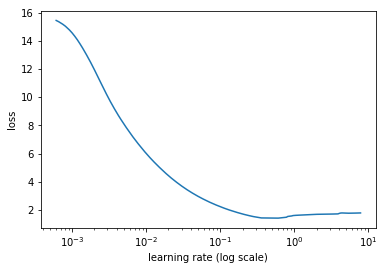

In [59]:
m.sched.plot(100)

In [60]:
lr=2e-1

In [65]:
m.fit(lr,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.929224   0.918555  
    1      0.89203    0.901883                               



[0.90188324]

In [66]:
m.fit(1e-2,2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.795074   0.785528  
    1      0.615525   0.620482                               



[0.62048215]

In [68]:
m.fit(1e-2,4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                               
    0      0.41527    0.44979   
    1      0.407679   0.463339                               
    2      0.408691   0.434603                               
    3      0.408138   0.452472                               



[0.45247236]